<a href="https://colab.research.google.com/github/venkatesh1226/CMPE255-DataMining/blob/main/DB_Scan_Mall_Customers_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the Data

In [ ]:
import pandas as pd

# Load the dataset
df_mall_customers = pd.read_csv('/content/drive/MyDrive/DM_Assignment_06/Mall_Customers.csv')

# Display the first few rows for an initial understanding
print(df_mall_customers.head())


   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


Data Cleaning and Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Check for missing values in the entire dataset
print(df_mall_customers.isnull().sum())

# Encoding the 'Gender' column
encoder = LabelEncoder()
df_mall_customers['Gender'] = encoder.fit_transform(df_mall_customers['Gender'])

# Standardizing the numerical columns
scaler = StandardScaler()
df_mall_customers[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(df_mall_customers[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# Dropping the 'CustomerID' as it's not useful for clustering
df_mall_customers.drop('CustomerID', axis=1, inplace=True)

# Display the preprocessed data
print(df_mall_customers.head())


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
   Gender       Age  Annual Income (k$)  Spending Score (1-100)
0       1 -1.424569           -1.738999               -0.434801
1       1 -1.281035           -1.738999                1.195704
2       0 -1.352802           -1.700830               -1.715913
3       0 -1.137502           -1.700830                1.040418
4       0 -0.563369           -1.662660               -0.395980


Feature Selection and Further Data Exploration

After cleaning and preprocessing the data, the next step is feature selection and further exploration to understand the relationships and distributions within the dataset. This will inform our approach to clustering.

Feature Selection

Choosing Relevant Features: For clustering, it's important to use features that will meaningfully group the customers. In this dataset, Gender, Age, Annual Income (k$), and Spending Score (1-100) are all potentially relevant.

Dimensionality Reduction (Optional): If the dataset were high-dimensional, we might consider techniques like PCA. However, with only a few relevant features, this isn't necessary here.

Further Data Exploration

Statistical Summary: A detailed statistical summary to understand the distributions of Age, Annual Income, and Spending Score.

Visual Exploration: Using plots to visualize the relationships and distributions of features. Scatter plots and pair plots can be particularly insightful.

Statistical Summary:
            Gender           Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  2.000000e+02        2.000000e+02            2.000000e+02
mean     0.440000 -1.021405e-16       -2.131628e-16           -1.465494e-16
std      0.497633  1.002509e+00        1.002509e+00            1.002509e+00
min      0.000000 -1.496335e+00       -1.738999e+00           -1.910021e+00
25%      0.000000 -7.248436e-01       -7.275093e-01           -5.997931e-01
50%      0.000000 -2.045351e-01        3.587926e-02           -7.764312e-03
75%      1.000000  7.284319e-01        6.656748e-01            8.851316e-01
max      1.000000  2.235532e+00        2.917671e+00            1.894492e+00


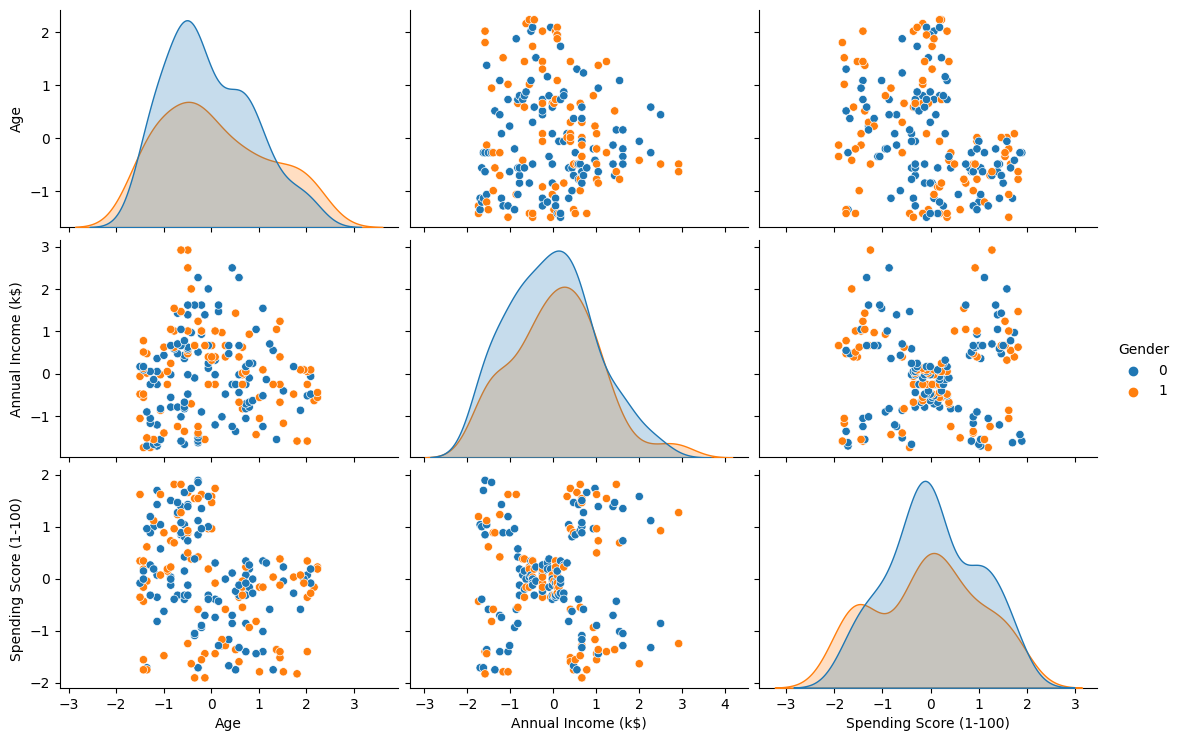

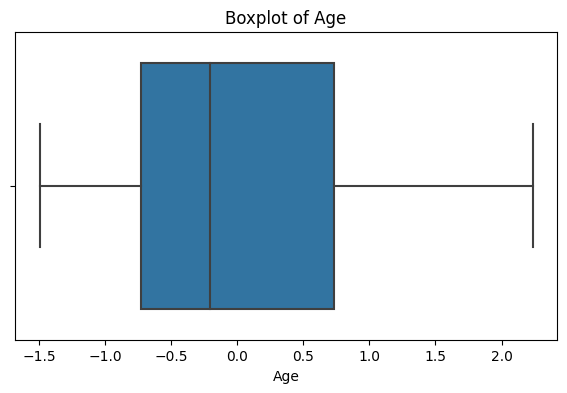

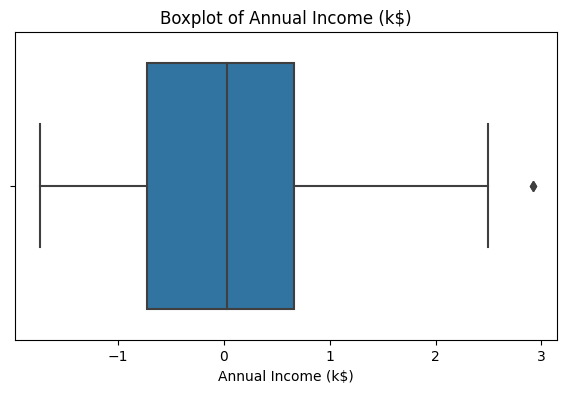

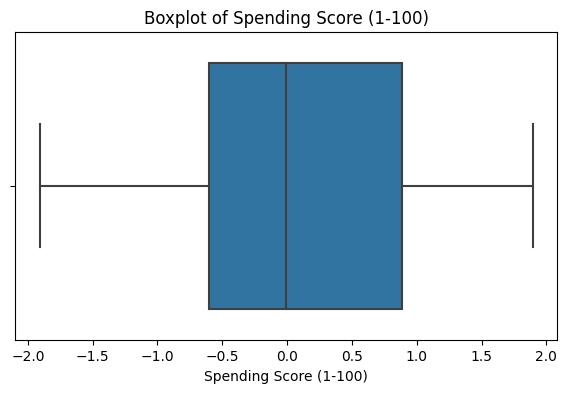

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Summary
print("Statistical Summary:\n", df_mall_customers.describe())

# Visual Exploration
# Pairplot to visualize relationships between features
sns.pairplot(df_mall_customers, hue='Gender', aspect=1.5)
plt.show()

# Boxplots for individual features
for column in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x=df_mall_customers[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


Choosing DBSCAN Parameters
The key parameters in DBSCAN are:

eps (epsilon): The maximum distance between two samples for one to be considered in the neighborhood of the other. This is not a global value but is specific to each datapoint.

min_samples: The minimum number of samples in a neighborhood for a point to be considered as a core point.

These parameters greatly influence the clustering results. Selecting the right values for eps and min_samples requires some experimentation and is often guided by domain knowledge and the scale of the data.

Applying DBSCAN
Let's apply DBSCAN with some initial values for these parameters:

In [ ]:
from sklearn.cluster import DBSCAN

# Applying DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(df_mall_customers)

# Adding the cluster labels to our DataFrame
df_mall_customers['Cluster'] = clusters

# Check the number of clusters and noise points
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')


Estimated number of clusters: 9
Estimated number of noise points: 105


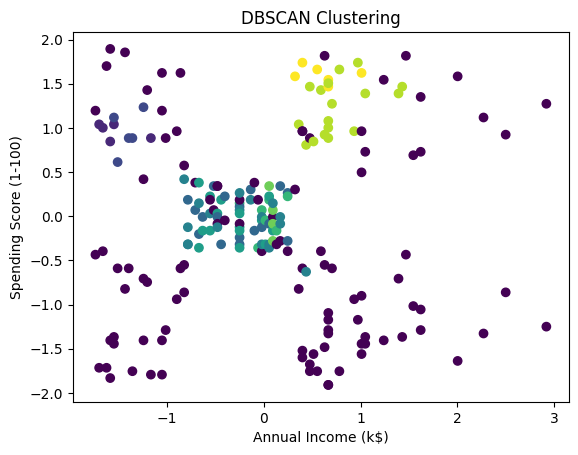

In [ ]:
plt.scatter(df_mall_customers['Annual Income (k$)'], df_mall_customers['Spending Score (1-100)'], c=df_mall_customers['Cluster'], cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()


 Parameter Tuning and Reevaluation

Tuning eps and min_samples

Adjusting eps: The eps value can significantly affect the number of noise points and clusters. If eps is too small, many data points may not be included in any cluster and be marked as noise. Conversely, if eps is too large, DBSCAN may merge distinct clusters.

Adjusting min_samples: This parameter determines the minimum size of a dense region. Increase it if too many points are being included in clusters (making clusters more stringent), or decrease it if too many points are marked as noise.

Finding the Optimal eps Value
One approach to finding a suitable eps value is to calculate the average distance to the nearest n points for each point, sort these distances, and look for a "knee" in the plot.

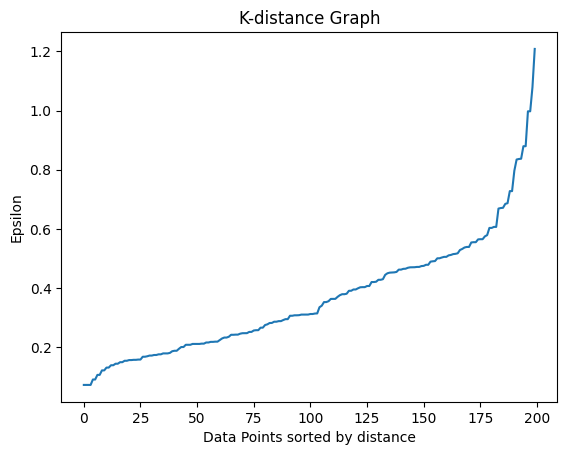

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Finding the optimal eps value
nearest_neighbors = NearestNeighbors(n_neighbors=5)
nearest_neighbors.fit(df_mall_customers)
distances, indices = nearest_neighbors.kneighbors(df_mall_customers)

# Sort and plot distances
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()


eps is 0.6

In [ ]:
# Reapply DBSCAN with new parameters
new_eps = 0.6  # Replace with the value you find from the graph
new_min_samples = 5  # Adjust based on your findings

dbscan = DBSCAN(eps=new_eps, min_samples=new_min_samples)
clusters = dbscan.fit_predict(df_mall_customers)

# Check the number of clusters and noise points again
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')


Estimated number of clusters: 12
Estimated number of noise points: 88


Evaluating the Clustering Results

Interpretation of Results

Clusters: The 12 clusters identified may represent distinct groups of customers with similar spending habits and income levels. It's essential to analyze these clusters to understand their characteristics.
Noise Points: DBSCAN marks outliers as noise. In a customer segmentation context, these noise points could represent unusual or exceptional customer behavior.

Visualizing the Refined Clusters
Visualizing the clusters again with the new parameters can provide insights into their distribution:

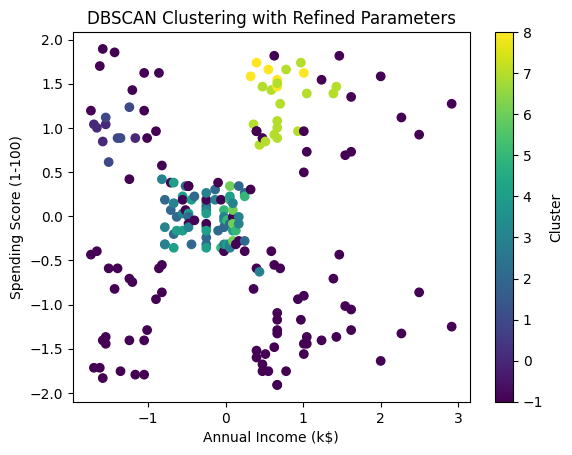

In [ ]:
plt.scatter(df_mall_customers['Annual Income (k$)'], df_mall_customers['Spending Score (1-100)'], c=df_mall_customers['Cluster'], cmap='viridis', label=df_mall_customers['Cluster'])
plt.title('DBSCAN Clustering with Refined Parameters')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
for cluster in range(-1, n_clusters):  # Including cluster -1 for noise
    cluster_data = df_mall_customers[df_mall_customers['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data.describe())



Cluster -1:
           Gender         Age  Annual Income (k$)  Spending Score (1-100)  \
count  105.000000  105.000000          105.000000              105.000000   
mean     0.485714    0.033320            0.115308               -0.363074   
std      0.502193    0.953668            1.212856                1.121360   
min      0.000000   -1.496335           -1.738999               -1.910021   
25%      0.000000   -0.563369           -1.013780               -1.366519   
50%      0.000000   -0.132768            0.360319               -0.590088   
75%      1.000000    0.584899            1.009200                0.496916   
max      1.000000    2.091999            2.917671                1.894492   

       Cluster  
count    105.0  
mean      -1.0  
std        0.0  
min       -1.0  
25%       -1.0  
50%       -1.0  
75%       -1.0  
max       -1.0  

Cluster 0:
       Gender       Age  Annual Income (k$)  Spending Score (1-100)  Cluster
count     5.0  5.000000            5.000000        